In [2]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import numpy as np
import os
import time
import graphviz
from matplotlib import pyplot as plot
import math

Предварительная обработка входных данных:   
* Вычитание среднего изображения, полученного по всем
изображения тренировочного множества   
*  Вычитание средней интенсивности, посчитанной по всем
изображениям тренировочной выборки   
* Центрирование изображений

In [3]:
dir_name = os.getcwd()

train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = torchvision.transforms.ToTensor()
)

100%|██████████| 170498071/170498071 [00:14<00:00, 11839365.92it/s]


Extracting /content/cifar-10-python.tar.gz to /content


In [4]:
means = np.empty(3)
stds = np.empty(3)
chain = [[] for i in range(3)]

for img, label in train_dataset:
  chain[0].append(img[0])
  chain[1].append(img[1])
  chain[2].append(img[2])

for i in range(3):
  chain[i] = torch.stack(chain[i])
  means[i] = chain[i].mean().item()
  stds[i] = chain[i].std().item()

train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(means, stds,inplace=True)
    ]
)

test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(means, stds,inplace=True)
    ]
)


In [5]:
train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = train_transforms
)
test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = False, download = True,
    transform = test_transforms
)

print('Number of train samples: {}, shape: {}'.format(len(train_dataset), train_dataset[0][0].shape))
print('Number of test samples: {}, shape: {}'.format(len(test_dataset), test_dataset[0][0].shape))

Files already downloaded and verified
Files already downloaded and verified
Number of train samples: 50000, shape: torch.Size([3, 32, 32])
Number of test samples: 10000, shape: torch.Size([3, 32, 32])


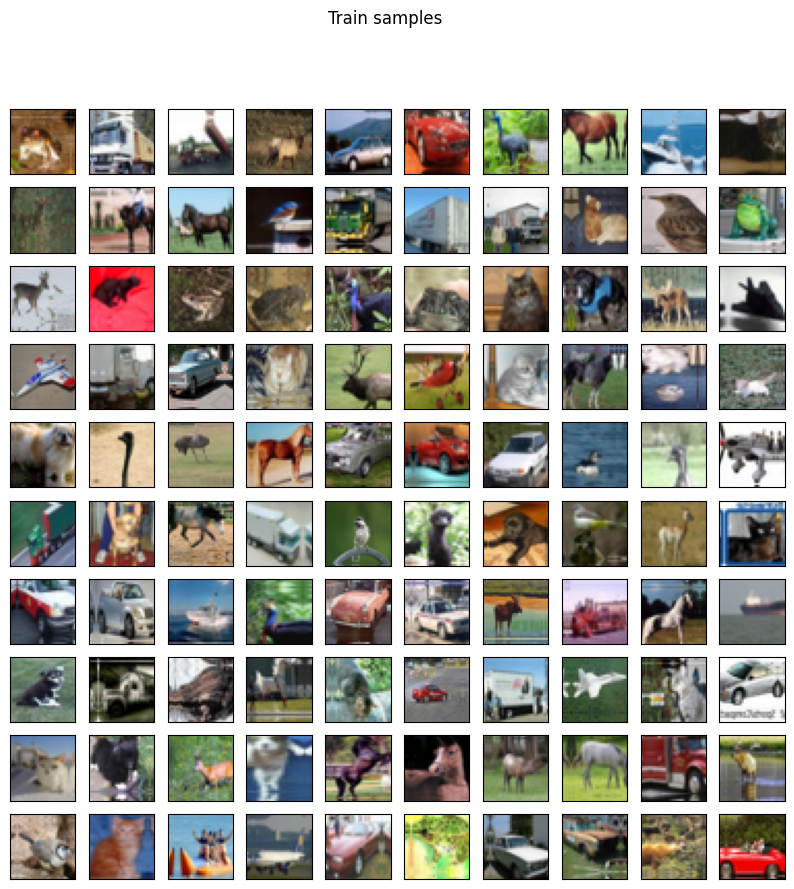

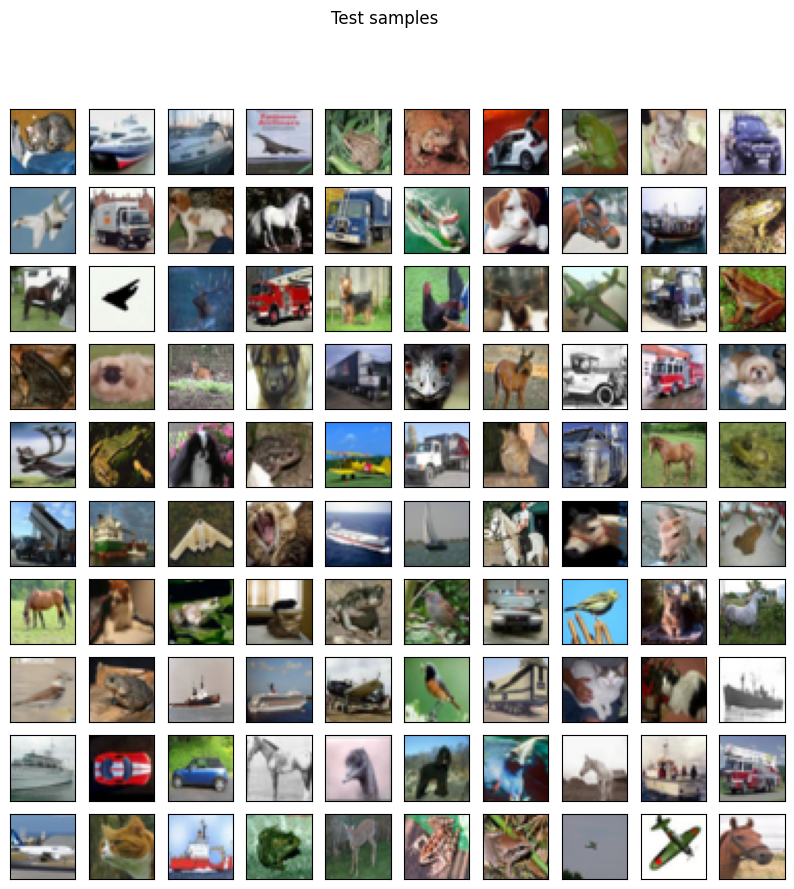

In [6]:
def denormal(image, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return image * stds + means

def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    figsize = (10, 10)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = denormal(images[i][0], means, stds).numpy().transpose(1, 2, 0)
        ax.imshow((img * 255).astype('uint8'))

show_images(train_dataset, 'Train samples')
show_images(test_dataset, 'Test samples')

In [26]:
class BottleneckLayer(torch.nn.Module):
    def __init__(self, input, growth_rate):
      super(BottleneckLayer, self).__init__()
      self.bn1 = torch.nn.BatchNorm2d(input)
      self.conv1 = torch.nn.Conv2d(input, 4*growth_rate, kernel_size=1,
                              bias=False)
      self.bn2 = torch.nn.BatchNorm2d(4*growth_rate)
      self.conv2 = torch.nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3,
                              padding=1, bias=False)
      self.relu = torch.nn.ReLU()

    def forward(self, x):
      out = self.bn1(x)
      out = self.relu(out)
      out = self.conv1(out)
      out = self.bn2(out)
      out = self.relu(out)
      out = self.conv2(out)
      out = torch.cat([out,x], 1)
      return out


class TransitionLayer(torch.nn.Module):
    def __init__(self, input, output):
      super(TransitionLayer, self).__init__()
      self.bn = torch.nn.BatchNorm2d(input)
      self.conv = torch.nn.Conv2d(input, output, kernel_size=1, bias=False)

    def forward(self, x):
      out = self.bn(x)
      out = torch.nn.ReLU()(out)
      out = self.conv(out)
      out = torch.nn.functional.avg_pool2d(out, 2)
      return out

nblocks = [6,12,24,16]
class DenseNet(torch.nn.Module):
    def __init__(self, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()

        self.growth_rate = growth_rate

        self.conv1 = torch.nn.Conv2d(3, 2 * self.growth_rate, kernel_size=3, padding=1, bias=False)
        next_input = 2 * self.growth_rate
        self.dense1 = self.dense_layers(next_input, nblocks[0])

        next_input += nblocks[0] * self.growth_rate
        next_out = math.floor(next_input * reduction)

        self.trans1 = TransitionLayer(next_input, next_out)
        next_input = next_out
        self.dense2 = self.dense_layers(next_input, nblocks[1])

        next_input += nblocks[1] * self.growth_rate
        next_out = math.floor(next_input * reduction)

        self.trans2 = TransitionLayer(next_input, next_out)
        next_input = next_out
        self.dense3 = self.dense_layers(next_input, nblocks[2])

        next_input += nblocks[2] * self.growth_rate
        out_planes = math.floor(next_input * reduction)

        self.trans3 = TransitionLayer(next_input, next_out)
        next_input = next_out
        self.dense4 = self.dense_layers(next_input, nblocks[3])

        next_input += nblocks[3] * self.growth_rate

        self.bn = torch.nn.BatchNorm2d(next_input)
        self.linear = torch.nn.Linear(next_input, num_classes)

    def dense_layers(self, input, nblock):
        layers = []
        for i in range(nblock):
            layers.append(BottleneckLayer(input, self.growth_rate))
            input += self.growth_rate
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.dense1(out)
        out = self.trans1(out)
        out = self.dense2(out)
        out = self.trans2(out)
        out = self.dense3(out)
        out = self.trans3(out)
        out = self.dense4(out)
        out = self.bn(out)
        out = torch.nn.ReLU()(out)
        out = torch.nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [27]:
cnn_model = DenseNet()
cnn_model

DenseNet(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): BottleneckLayer(
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU()
    )
    (1): BottleneckLayer(
      (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU()
    )
    (2): BottleneckLayer(
      (bn1): BatchNorm2d(48, eps=1

In [28]:
learning_rate = 0.001
num_epochs = 20
batch_sizes = 100

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_sizes, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_sizes, shuffle = False
)


In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = learning_rate)

def get_accuracy(data_loader, model, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

start_time = time.time()
for epoch in range(num_epochs):
  start_epoch = time.time()

  for i, (images, labels) in enumerate(train_data_loader):
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = cnn_model(images)

      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()

  time_epoch = time.time() - start_epoch
  print('Epoch[{}]: Train accuracy = {:.4f}, Time epoch = {:.4f}'.
        format(epoch,get_accuracy(train_data_loader, cnn_model, device),time_epoch))

total_time = time.time() - start_time
print('Total time {}'.format(total_time))

Epoch[0]: Train accuracy = 0.6547, Time epoch = 65.7797
Epoch[1]: Train accuracy = 0.7507, Time epoch = 69.1309
Epoch[2]: Train accuracy = 0.7957, Time epoch = 64.6275
Epoch[3]: Train accuracy = 0.8277, Time epoch = 65.1617
Epoch[4]: Train accuracy = 0.8478, Time epoch = 64.0464
Epoch[5]: Train accuracy = 0.8588, Time epoch = 64.2896
Epoch[6]: Train accuracy = 0.8659, Time epoch = 63.8031
Epoch[7]: Train accuracy = 0.8819, Time epoch = 65.1305
Epoch[8]: Train accuracy = 0.8878, Time epoch = 63.5913
Epoch[9]: Train accuracy = 0.8996, Time epoch = 64.0189
Epoch[10]: Train accuracy = 0.9042, Time epoch = 63.2744
Epoch[11]: Train accuracy = 0.9091, Time epoch = 64.6884
Epoch[12]: Train accuracy = 0.9202, Time epoch = 63.4334
Epoch[13]: Train accuracy = 0.9221, Time epoch = 64.0768
Epoch[14]: Train accuracy = 0.9246, Time epoch = 62.5635
Epoch[15]: Train accuracy = 0.9308, Time epoch = 63.5399
Epoch[16]: Train accuracy = 0.9398, Time epoch = 63.4758
Epoch[17]: Train accuracy = 0.9344, Time 

In [31]:
print('Test accuracy = {}'.format( get_accuracy(test_data_loader, cnn_model, device)))

Test accuracy = 0.8967999815940857
